Master TSI - Méthodes avancées en TSI - 10 Mars 2020

# TP2 : Débruitage de signaux 1D à l'aide d'ondelettes et AMR 2D

## 1. Téléchargements et compte-rendu
### 1.1 Téléchargements
Tous les téléchargements se font sur Ametice.

### 1.2. Rendu du TP

Un compte rendu vous est demandé en deux parties :
<ul>
<li> le IPtyhon notebook ci-dessous rempli (format .ipynb)</li>
<li> un ficher pdf formé à partir du notebook ci-dessus (onglet File puis Download as)</li>
</ul>

Les deux sont à rendre via Ametice le <b>vendredi 13 mars à midi</b>. Le nom des fichiers devra obligatoirement comporter votre nom. Tout retard sera sanctionné.

## 2. Utilisation des librairies générales

In [23]:
#pour ce TP nous avons besoin de la bibliothèque numpy
import numpy as np

In [24]:
#pour ce TP nous avons besoin de la bibliothèque matplotlib
import matplotlib.pyplot as plt

Afin de manipuler des ondelettes en Python, nous utiliserons la boîte à outils PyWavelets. Pour plus d'informations, on pourra se référer à la documentation de cette boîte à outils disponible à l'adresse suivante https://pywavelets.readthedocs.io/en/latest/

In [25]:
# on charge la librairie ondelettes
import pywt

## 3. Application au débruitage de signaux
On suppose ici que l'on possède une observation bruitée du signal d'intérêt et l'objectif est d'estimer le signal original à partir de l'observation.

### Mesures de qualité
Pour comparer les performances des algorithmes de restauration on utilisera le SNR (Signal to noise ratio). Si $\tilde{y}$ est le signal restauré et $y$ le signal original non bruité

\begin{equation}
SNR(\tilde{y},y)=10\log_{10}\left(\frac{\parallel y\parallel_2^2}{\parallel y-\tilde{y}\parallel_2^2}\right) \qquad \text{où} \quad \parallel y\parallel_2^2=\sum\limits_{n_1=0}^{N-1}\sum\limits_{n_2=0}^{N-1} |y_{n_1,n_2}|^2.
\end{equation}

### Exercice 1 : mesure de qualité
Ecrire une fonction SNR qui prend en argument 2 images : $\tilde{y}$ (l'image restaurée) et  $y$ (l'image originale), et qui calcule le SNR entre ces deux images.

In [26]:
# Returns signal noise ratio
def SNR(Ir,Io):
    """
    -Ir: restored image
    -Io: original image
    """
    
    return(10*np.log10(np.linalg.norm(Io)**2/np.linalg.norm(Io-Ir)**2))

### Exercice 2  : Génération des observations bruitées
Générer des observations bruitées du signal ramp en lui ajoutant un bruit gaussien, centré, de variance $\sigma^2=100$. On utilisera pour cela la fonction randn (np.random.randn).

In [27]:
N=256
ramp=np.concatenate((np.arange(0,N/2,1),np.arange(-N/2,0,1)))

In [38]:
# Create gaussian noise
sigma = 10
mu = 0
Noise = sigma * np.random.randn(len(ramp), ramp.size) + mu

### Exercice 3  :  Implémentation du filtre de Wiener
Ci dessous, vous est donnée une fonction filtredebruitwiener qui prend en entrée un signal $x$ et un écart-type  $\sigma$, et ressort la fonction de transfert du filtre de Wiener.

On rappelle que la formule qui donne le filtre de restauration de Wiener dans le cas du débruitage est
$$\hat{h}(\omega)=\frac{\mathcal{S}_X(\omega)}{\mathcal{S}_X(\omega)+\sigma^2}$$
où $\mathcal{S}_X$ est la densité spectrale du processus aléatoire $X$ dont le signal de départ $x$ est une réalisation.

Remarque : ici on considère que le signal de départ $x$ est une réalisation d'un processus aléatoire $X$ sous jacent. Pour obtenir $\mathcal{S}_X$ on utilise la méthode du "périodogramme" sur une seule réalisation.
Nous avons une seule réalisation, donc on estime directement $\mathcal{S}_X=\frac{|\widehat{x}|^2}{N}$ avec $\widehat{x}$ la transformée de Fourier finie de $x$ et $N$ sa taille.

In [39]:
def filtredebruitwiener(x,sigma):
    Sx=np.abs(np.fft.fft(x))**2/x.size
    h=Sx/(Sx+sigma**2)
    return h

### Exercice 4  :  Application du filtre de Wiener pour restaurer le signal ramp
Appliquer le filtre de Wiener au signal ramp bruité afin d'obtenir une estimation du signal original.

Calculer les SNR entre : le signal original et le signal bruité et le signal original et le signal estimé.

Vérifier que le premier SNR (signal original/bruité) < second SNR (signal original/estimé)

Afficher le résultat obtenu

In [43]:
# Add noise
signal_bruite = ramp + Noise

# Apply filter
signal_estime = filtredebruitwiener(signal_bruite,sigma)
signal_estime = np.real(np.fft.ifft(signal_estime* np.fft.fft(signal_bruite)))

# Print SNR for each signal
print("SNR(signal original/bruité) ", SNR(ramp,signal_bruite))
print("SNR(signal original/estimé) ", SNR(ramp,signal_estime))

SNR(signal original/bruité)  17.475048845684114
SNR(signal original/estimé)  7.7228894478791075


### Exercice 5  : Seuillage des coefficients d'ondelettes pour restaurer le signal ramp
A l'aide de la fonction threshold, seuiller les coefficients d'ondelettes du signal ramp bruité. On seuillera tous les coefficients de détails mais on veillera à ne pas seuiller les coefficients d'approximation.

Calculer les SNR entre : le signal original et le signal bruité et le signal original et le signal estimé.

Vérifier que le premier SNR (signal original/bruité) < second SNR (signal original/estimé)

Afficher le résultat obtenu

In [44]:
c3 = pywt.wavedec(ramp, 'db2',level=3, mode='periodization')
cA3, cD3, cD2, cD1 = c3

cD3 = pywt.threshold(cD3, 15, mode='soft')
cD2 = pywt.threshold(cD2, 15, mode='soft')
cD1 = pywt.threshold(cD1, 15, mode='soft')

c4 = cA3, cD3, cD2, cD1
sig_est_ond =  pywt.waverec( c4 ,'db2', mode='periodization')

print("SNR(signal original/bruité) ", SNR(signal_bruite,ramp))
print("SNR(signal original/estimé) ", SNR(sig_est_ond,ramp))

SNR(signal original/bruité)  -6.694500109272799
SNR(signal original/estimé)  30.15218134806469


On considère à présent un nouveau signal "piece-regular.mat". Nous le chargerons à l'aide de la librairie scipy comme écrit ci-dessous.

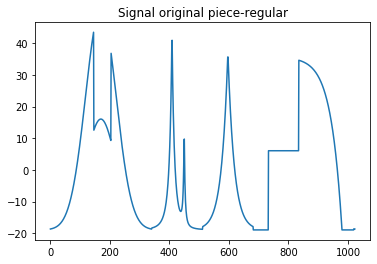

(1024, 1)

In [80]:
from scipy.io.matlab import mio
x = mio.loadmat('piece-regular.mat')
x=x['f']

plt.figure()
plt.plot(x)
plt.title('Signal original piece-regular')
plt.show()

x.shape

### Exercice 6  : Restauration du signal piece-regular (facultatif)
Générer des observations bruitées du signal piece-regular en lui ajoutant un bruit gaussien, centré, de variance $\sigma^2=1$. 

Appliquer le filtre de Wiener au signal piece-regular bruité afin d'obtenir une estimation du signal original.

Calculer les SNR entre : le signal original et le signal bruité et le signal original et le signal estimé.

Vérifier que le premier SNR (signal original/bruité) < second SNR (signal original/estimé)

Afficher le résultat obtenu

A l'aide de la fonction threshold, seuiller les coefficients d'ondelettes du signal piece-regular bruité. On seuillera tous les coefficients de détails mais on veillera à ne pas seuiller les coefficients d'approximation.

Calculer les SNR entre : le signal original et le signal bruité et le signal original et le signal estimé.

Vérifier que le premier SNR (signal original/bruité) < second SNR (signal original/estimé)

Afficher le résultat obtenu

(1024, 1024)
(1024, 1024)


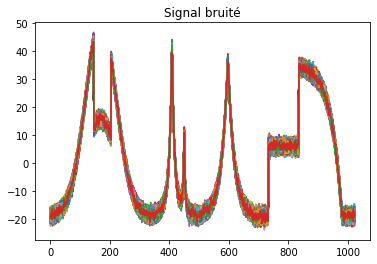

SNR(signal original/bruité) - Wiener -5.039360798016914
SNR(signal original/estimé) - Wiener 12.5295826588547


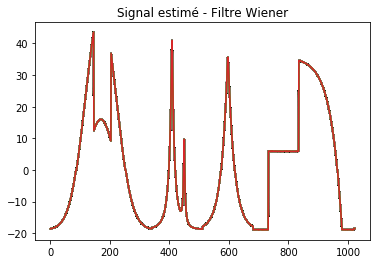

SNR(signal original/bruité) - Seuilage ondelletes  -5.039360798016914
SNR(signal original/estimé) - Seuilage ondelletes 307.47103781927444


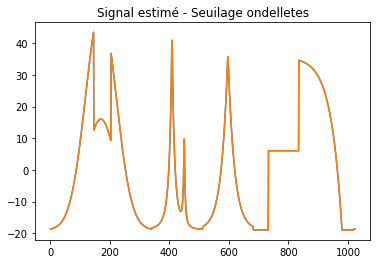

In [81]:
# Create Noise
sigma = 1
mu = 0
Noise = sigma * np.random.randn(len(x), x.size) + mu
print(Noise.shape)
# Add noise
signal_bruite = x + Noise
print(signal_bruite.shape)
plt.figure()
#plt.plot(signal_bruite)
plt.plot(signal_bruite[0])
plt.title('Signal bruité')
plt.show()

# Apply wiener filter
signal_estime = filtredebruitwiener(signal_bruite,sigma)
signal_estime = np.real(np.fft.ifft(signal_estime* np.fft.fft(signal_bruite)))

print("SNR(signal original/bruité) - Wiener", SNR(signal_bruite,x))
print("SNR(signal original/estimé) - Wiener", SNR(signal_estime,x))

plt.figure()
plt.plot(signal_estime)
plt.title('Signal estimé - Filtre Wiener')
plt.show()

# Apply wavelet decomposition and thresholding
c3 = pywt.wavedec(x, 'db2',level=3, mode='periodization')
cA3, cD3, cD2, cD1 = c3

cD3 = pywt.threshold(cD3, 15, mode='soft')
cD2 = pywt.threshold(cD2, 15, mode='soft')
cD1 = pywt.threshold(cD1, 15, mode='soft')

c4 = cA3, cD3, cD2, cD1
sig_est_ond =  pywt.waverec( c4 ,'db2', mode='periodization')

print("SNR(signal original/bruité) - Seuilage ondelletes ", SNR(signal_bruite,x))
print("SNR(signal original/estimé) - Seuilage ondelletes", SNR(sig_est_ond,x))

plt.figure()
plt.plot(np.real(sig_est_ond))
plt.title('Signal estimé - Seuilage ondelletes')
plt.show()

## 4. Analyse multirésolution 2D
Dans ce dernier exercice nous allons travailler avec l'image de Lena
<img src="lena.png" alt="Lena" width="128" height="128"/>

### Chargement d'une image

In [58]:
import scipy.ndimage as ndim
import imageio
#on charge l'image de lena à l'aide de la fonction imread de la bibliothèque ndimage de scipy
y = imageio.imread("lena.png")

#on ne garde que la première composante car niveau de gris
#y=y[:,:,0]
#l'image est de type int ou float on la cast en float pour pouvoir faire des calculs
# et on la remet à l'échelle si besoin
if (y.dtype=='float32') :
    y=y*255
#l'image est de type int on la cast en float pour pouvoir faire des calculs
y=y.astype(float)
#la taille de l'image peut s'obtenir à l'aide de l'attribut shape
[n1,n2]=y.shape

# on affiche le maximum et le minimum pour vérifier que les valeurs de niveau de gris varient 
# bien entre 0 et 255 (et pas 0 et 1 par exemple)

print([y.min(), y.max()])

[25.0, 245.0]


### Affichage d'une image

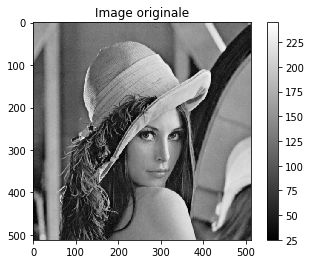

In [59]:
import matplotlib.pyplot as plt
#on affiche l'image à l'aide de la fonction imshow de la bibliothèque pyplot de matplotlib
#on donne un numero à la figure
plt.figure(1)
#on l'affiche en niveau de gris
plt.imshow(y, cmap="gray")
#on affiche la colorbar associée
plt.colorbar()
#on lui donne un titre
plt.title('Image originale')
#on affiche tout cela sur la figure 1
plt.show()

### Exercice 7 : Analyse multirésolution 2D 
Le but de cet exercice est de calculer la décomposition multirésolution de l'image test Lena. <br />

Calculer la décomposition multirésolution de l'image test Lena sur $j_m=3$ niveaux de décomposition (mêmes ondelettes qu'étudiées à la section précédente) et stockez le résultat dans la variable appelée <i>coeffs</i>. (Pour cela on utilisera la commande <i>wavedec2</i> et on s'assurera de faire des extensions périodiques (mode='periodization')). Observer la manière dont sont stockés les coefficients. <br />

Visualiser les coefficients obtenus et observer les sous-bandes obtenues. On fera cela de deux manières:
<ul>
<li> Pour visualiser tous les coefficients d'un coup, on utilise la commande <i>coeffs_to_array</i> qui range les coefficients de décomposition dans un tableau. (On pourra utiliser les options vmin et vmax de imshow pour mieux voir le contenu de ce tableau). </li> 
<li>Pour visualiser chaque sous-bande, on extrait d'abord chaque sous-bande 
<br>
<i>cA3, (cH3, cV3, cD3),(cH2, cV2, cD2),(cH1, cV1, cD1) = coeffs</i>
<br>
et on visualise chaque sous-bande de coefficients indépendamment.</li> 
</ul>

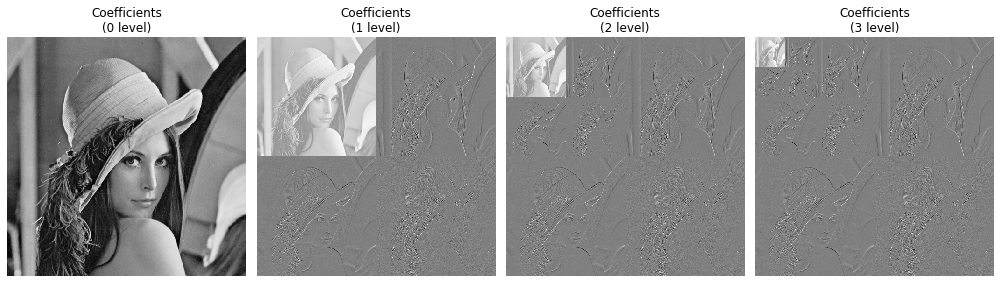

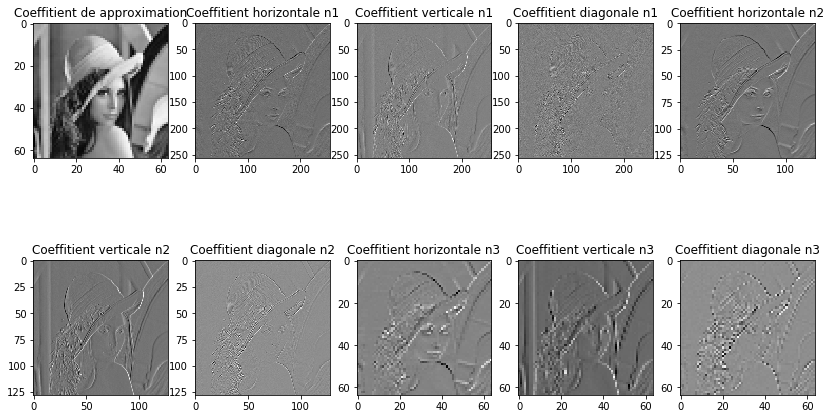

In [87]:
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis


c = pywt.wavedec2(y,'db1',level=3,mode='periodization')


# Premiere maniere
shape = y.shape

# Normalize coeffs
max_lev = 3       # how many levels of decomposition to draw
label_levels = 3  # how many levels to explicitly label on the plots

fig, axes = plt.subplots(1, 4, figsize=[14, 8])
for level in range(0, max_lev + 1):

    # compute the 2D DWT
    c = pywt.wavedec2(y, 'db1', mode='periodization', level=level)
    # normalize each coefficient array independently for better visibility
    c[0] /= np.abs(c[0]).max()
    for detail_level in range(level):
        c[detail_level + 1] = [d/np.abs(d).max() for d in c[detail_level + 1]]
    # show the normalized coefficients
    arr, slices = pywt.coeffs_to_array(c)
    axes[ level].imshow(arr, cmap=plt.cm.gray)
    axes[level].set_title('Coefficients\n({} level)'.format(level))
    axes[level].set_axis_off()

plt.tight_layout()
plt.show()


cA3, (cH3, cV3, cD3),(cH2, cV2, cD2),(cH1, cV1, cD1) = c

fig, axes = plt.subplots(2, 5, figsize=[14, 8])
axes[0][0].imshow(cA3, cmap=plt.cm.gray)
axes[0][0].set_title('Coeffitient de approximation')
axes[0][1].imshow(cH1, cmap=plt.cm.gray)
axes[0][1].set_title('Coeffitient horizontale n1')
axes[0][2].imshow(cV1, cmap=plt.cm.gray)
axes[0][2].set_title('Coeffitient verticale n1')
axes[0][3].imshow(cD1, cmap=plt.cm.gray)
axes[0][3].set_title('Coeffitient diagonale n1')
axes[0][4].imshow(cH2, cmap=plt.cm.gray)
axes[0][4].set_title('Coeffitient horizontale n2')
axes[1][0].imshow(cV2, cmap=plt.cm.gray)
axes[1][0].set_title('Coeffitient verticale n2')
axes[1][1].imshow(cD2, cmap=plt.cm.gray)
axes[1][1].set_title('Coeffitient diagonale n2')
axes[1][2].imshow(cH3, cmap=plt.cm.gray)
axes[1][2].set_title('Coeffitient horizontale n3')
axes[1][3].imshow(cV3, cmap=plt.cm.gray)
axes[1][3].set_title('Coeffitient verticale n3')
axes[1][4].imshow(cD3, cmap=plt.cm.gray)
axes[1][4].set_title('Coeffitient diagonale n3')
plt.show()

### Exercice 8 : inverse de l'analyse multirésolution 2D 
Reconstruire l'image de Lena à l'aide de la commande <i>waverec2</i> à partir des coefficients de décomposition obtenus à l'exercice précédent. <br />
Afficher l'image obtenue. Vérifier que l'on a bien reconstruction parfaite (en calculant par exemple l'erreur de reconstruction ou le SNR).

In [95]:
c = pywt.wavedec2(y,'db1',level=3,mode='periodization')
im_rec = pywt.waverec2(c, 'db1', mode='periodization')

print("SNR :", SNR(im_rec,y)) #300

error1 = np.mean(np.abs(im_rec - y)**2)
print("Erreur quadratic moyenne , niveau 3:", error1)

SNR : 301.3732398139811
Erreur quadratic moyenne , niveau 3: 2.146401484475679e-31
